# Homework 2
Tim Kmecl

## Setup

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd


In [2]:
def toy_data(n, seed=None):
    if seed is not None:
        np.random.seed(seed)
    x = np.random.randn(n, 8)
    z = 0.4 * x[:, 0] - 0.5 * x[:, 1] + 1.75 * x[:, 2] - 0.2 * x[:, 3] + x[:, 4]
    y = np.random.rand(n) > 1 / (1 + np.exp(-z))
    return x, y


In [3]:
def log_loss(y, p):
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

In [4]:
# def accuracy(y, p):
#     return np.mean(y == p)

# def standard_error(y, p):
#     return np.sqrt(np.var(y == p) / len(y))

# def confidence_interval(y, p):
#     se = standard_error(y, p)
#     return accuracy(y, p) - 1.96 * se, accuracy(y, p) + 1.96 * se


def risk(y, p):
    return np.mean(log_loss(y, p))

def risk_se(y, p):
    return np.sqrt(np.var(log_loss(y, p)) / len(y))

def risk_ci(y, p):
    se = risk_se(y, p)
    r = risk(y, p)
    return r - 1.96 * se, r + 1.96 * se

In [5]:
def predictions(model, x, eps=1e-8):
    return model.predict_proba(x)[:, 1]*(1-eps) + eps/2

In [6]:
x_dgp, y_dgp = toy_data(100000, 0)

In [7]:
learner = LogisticRegression(penalty='none', solver='newton-cg')

In [8]:
model = learner.fit(x_dgp, y_dgp)
p = predictions(model, x_dgp)
print('Risk SE: {:.4f}'.format(risk_se(y_dgp, p)))

Risk SE: 0.0017


By fitting the model on this dataset and then calculating the standard error of its prediction, we see that the standard error, which is the standard deviation of the risk, is less than 0.005. We can therefore expect the true risk will be off by no more than this, i.e. the change will be on the third digit.

## Holdout estimation

### Model loss estimator variability due to test data variability

In [9]:
x, y = toy_data(50, 1011)

In [10]:
model = learner.fit(x, y)

In [11]:
p = predictions(model, x_dgp)
r_proxy = risk(y_dgp, p)

In [12]:
rs = []
ses = []
cis = []

for i in range(1000):
    x, y = toy_data(50)
    p = predictions(model, x)
    rs.append(risk(y, p))
    ses.append(risk_se(y, p))
    cis.append(risk_ci(y, p))

In [13]:
rs = np.array(rs)
ses = np.array(ses)
cis = np.array(cis)

In [14]:
r_diffs = rs - r_proxy
mean_diff = np.mean(r_diffs)
median_se = np.median(ses)

risk05 = risk(y_dgp, 0.5)

contains_true = (cis[:, 0] <= r_proxy) & (r_proxy <= cis[:, 1])
contains_true_percent = np.mean(contains_true) * 100

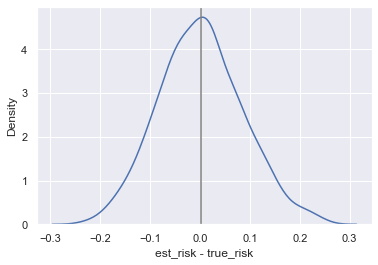

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.kdeplot(r_diffs)
plt.axvline(mean_diff, color="gray")
plt.xlabel('est_risk - true_risk')
plt.ylabel('Density')
plt.show()

In [16]:
print('True risk proxy: {:.4f}'.format(r_proxy))
print('Mean difference: {:.4f}'.format(mean_diff))
print('0.5-0.5 baseline true risk: {:.4f}'.format(risk05))
print('Median standard error: {:.4f}'.format(median_se))
print('Percentage of 95CI that contain the true risk proxy: {:.1f}'.format(contains_true_percent))

True risk proxy: 0.5310
Mean difference: 0.0019
0.5-0.5 baseline true risk: 0.6931
Median standard error: 0.0833
Percentage of 95CI that contain the true risk proxy: 93.3


We see that the mean difference is near 0. Median SE is quuiet large relative to the difference between true risk and 0.5-0.5 risk. Percentage inside CI is a bit less than 95%, but near. This is probably because of the small amount of data, which causes the distribution to not be similar enough to gaussian (assumpiton when calculating CI is that it is gaussian), which we can also see from the plot (the same also holds to varying degrees for later experiments).


For practical use, we see that the CI obtained in this is approximately correct, since it empirically contains true risk almost 95 percent od the times, however it is a bit too optimistic. Nonetheless it gives us a good estimation. But we also see that SE on the small dataset is relatively large, so the CIs are wide, and almost useless for evaluating small improvements in practice. In general, small datasets cause high variability.


If train was larger, true risk proxy should decrease. Percentage of CI that contain true risk should on average approach 95, since the distribution would be closer to gaussian.


If test was larger, mean SE would decrease, since we would get a "better estimate" - our sample size would be larger and variability lower. Mean difference should on average be closer to zero, and other results shouldn't be affected. Reverse also holds.

### Overestimation of the deployed model’s risk

In [17]:
diffs = []
for i in range(50):
    x1, y1 = toy_data(50, 1011+2*i)
    model1 = learner.fit(x1, y1)
    risk1 = risk(y_dgp, predictions(model1, x_dgp))

    x2, y2 = toy_data(50, 1011+2*i+1)
    x, y = np.vstack([x1, x2]), np.hstack([y1, y2])
    model2 = learner.fit(x, y)
    risk2 = risk(y_dgp, predictions(model2, x_dgp))

    diffs.append(risk1 - risk2)

In [18]:
print('Summary of true risk h1 - true risk h2:')
df = pd.DataFrame({
    '': diffs
})
print(df.describe())

Summary of true risk h1 - true risk h2:
                
count  50.000000
mean    0.438838
std     1.256488
min    -0.069258
25%     0.053264
50%     0.097529
75%     0.213666
max     6.612893



We can see that the model fitted on smaller dataset performs worse almost all the time - sometimes a lot worse, rarely even a little better - as we can see from the fact that risk is usually higher on the one fitted on less data.


Evaluating the model by fitting it on the subset of data will introduce a bias - risk estimate will be pessimistic. When evaluating models this way, we can expect the final model to perform better. This also shows us that we should use all the data we have to train the finall model if we want the lowest loss possible from it.


If we increase the amount of data, the variability of both the estimate and the model itself should decrease. With large enough dataset, the amount of times the model fitted on the subset is better than the one fitted on all the data should reduce to 0 due to this. Also with larger datasets, the average difference should decrease, and approach zero with really large amount of data, since at this point even the smaller subset would be sufficiently large for the model to be able to generalize well (estimation error goes towards zero and only approximation error remains).


### Loss estimator variability due to split variability

In [19]:
x0, y0 = toy_data(100, 1011)
model0 = learner.fit(x0, y0)
r_proxy = risk(y_dgp, predictions(model0, x_dgp))

In [20]:
rs = []
ses = []
cis = []

np.random.seed(1011)
for i in range(1000):
    idx = np.random.permutation(100)
    x1, y1 = x0[idx[:50]], y0[idx[:50]]
    x2, y2 = x0[idx[50:]], y0[idx[50:]]
    model = learner.fit(x1, y1)
    p = predictions(model, x2)
    rs.append(risk(y2, p))
    ses.append(risk_se(y2, p))
    cis.append(risk_ci(y2, p))

In [21]:
rs = np.array(rs)
ses = np.array(ses)
cis = np.array(cis)

In [22]:
r_diffs = rs - r_proxy
mean_diff = np.mean(r_diffs)
median_se = np.median(ses)

contains_true = (cis[:, 0] <= r_proxy) & (r_proxy <= cis[:, 1])
contains_true_percent = np.mean(contains_true) * 100

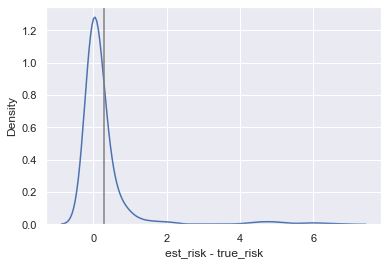

In [23]:
sns.kdeplot(r_diffs)
plt.axvline(mean_diff, color="gray")
plt.xlabel('est_risk - true_risk')
plt.ylabel('Density')
plt.show()

In [24]:
print('True risk proxy: {:.4f}'.format(r_proxy))
print('Mean difference: {:.4f}'.format(mean_diff))
print('Median standard error: {:.4f}'.format(median_se))
print('Percentage of 95CI that contain the true risk proxy: {:.1f}'.format(contains_true_percent))

True risk proxy: 0.5169
Mean difference: 0.2993
Median standard error: 0.1318
Percentage of 95CI that contain the true risk proxy: 85.8



Mean difference is positive, and larger than median SE. We see that the amount of times true risk is within 95% CI is visibly lower than 95%. This is due to the bias - derivation of SE and consequently CI doesn't take into account the bias introduced by fitting the model on smaller dataset. 


In practice, as in the previous section, we can expect the final model to perform better than our evaluation suggest. We can also conclude that 95% CI do not necessarily contain true risk 95% of the time, but less, if bias is big enough. This needs to be taken into consideration during evaluation.


If the datasets were larger, mean difference would decrease, since as before the performance of the model with less train data would approach the one with more  due to estimation error decrease. But because there would also be more test data, the larger sample size would decrease SE. This would make CIs shorter, therefore it is hard to say what would happen with percentage of times true risk is within them. And vice versa for smaller dataset.


By putting more samples into train as opposed to test set, bias would be reduced (the amount of data for fitting the model will be closer to the final model) - smaller mean difference. With less data being used for testing, estimates would be less accurate -meaning larger SE and wider CIs. Due to this, true risk being inside CI would be closer to 95%. Reverse holds for larger proportion used for testing.

## Cross-validation

In [25]:
def cross_validation(x, y, k, seed):
    np.random.seed(seed)
    idx = np.random.permutation(len(y))
    x, y = x[idx], y[idx]
    id_splits = np.array_split(idx, k)
    x_folds, y_folds = np.array_split(x, k), np.array_split(y, k)
    losses = np.zeros(len(y))
    for i in range(k):
        x_tr = np.concatenate([x_folds[j] for j in range(k) if j != i])
        y_tr = np.concatenate([y_folds[j] for j in range(k) if j != i])
        x_test = x_folds[i]
        y_test = y_folds[i]
        model = learner.fit(x_tr, y_tr)
        p = predictions(model, x_test)
        losses[id_splits[i]] = log_loss(y_test, p)
    return losses

In [ ]:
# 2-fold, 4-fold, 10-fold, 20x10-fold, LOO
r_diffs = [[] for i in range(5)]
ses = [[] for i in range(5)]
ci_contains = [[] for i in range(5)]
# r_proxies = []

for i in range(500):
    print(i)
    x0, y0 = toy_data(100, 1011 + i)
    model0 = learner.fit(x0, y0)
    r_proxy = risk(y_dgp, predictions(model0, x_dgp))
    # r_proxies.append(r_proxy)


    losses = [[] for i in range(5)]
    losses[0] = cross_validation(x0, y0, 2, 1011)
    losses[1] = cross_validation(x0, y0, 4, 1011)
    losses[2] = cross_validation(x0, y0, 10, 1011)

    losses[3] = np.zeros(len(y0))
    for j in range(20):
        losses[3] += cross_validation(x0, y0, 10, 1011+j)
    losses[3] /= 20

    losses[4] = cross_validation(x0, y0, len(y0), 1011)


    for j in range(5):
        r = np.array(losses[j]).mean()
        se = np.sqrt(np.var(losses[j]) / len(losses[j]))
        ci = [r - 1.96 * se, r + 1.96 * se]

        r_diff = r - r_proxy
        contains_true = (ci[0] <= r_proxy) & (r_proxy <= ci[1])
        
        r_diffs[j].append(r_diff)
        ses[j].append(se)
        ci_contains[j].append(contains_true)

In [28]:
# approaches = ['2-fold', 'LOO', '10-fold', '4-fold', '20x10-fold']
approaches = ['2-fold', '4-fold', '10-fold', '20x10-fold', 'LOO']
# print('True risk proxy: {:.4f}'.format(r_proxy))
for j in range(5):
    mean_diff = np.mean(r_diffs[j])
    median_se = np.median(ses[j])
    # contains_true_percent = np.array(ci_contains[j])
    contains_true_percent = np.mean(ci_contains[j]) * 100

    print()
    print('', approaches[j])
    print('Mean difference: {:.4f}'.format(mean_diff))
    print('Median standard error: {:.4f}'.format(median_se))
    print('Percentage of 95CI that contain the true risk proxy: {:.1f}'.format(contains_true_percent))


 2-fold
Mean difference: 0.3112
Median standard error: 0.1125
Percentage of 95CI that contain the true risk proxy: 66.8

 4-fold
Mean difference: 0.0397
Median standard error: 0.0834
Percentage of 95CI that contain the true risk proxy: 91.4

 10-fold
Mean difference: 0.0127
Median standard error: 0.0770
Percentage of 95CI that contain the true risk proxy: 93.4

 20x10-fold
Mean difference: 0.0120
Median standard error: 0.0763
Percentage of 95CI that contain the true risk proxy: 93.2

 LOO
Mean difference: 0.0011
Median standard error: 0.0745
Percentage of 95CI that contain the true risk proxy: 93.2


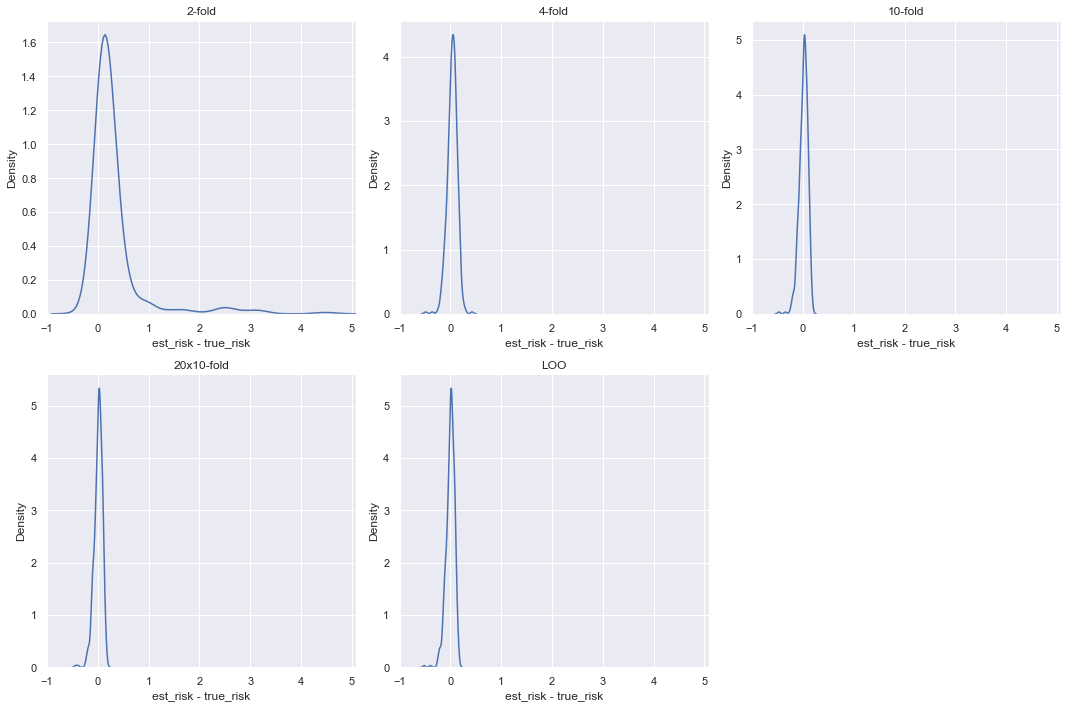

In [29]:
# plot the distribution of the differences, use subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(5):
    sns.kdeplot(r_diffs[i], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(approaches[i])
    axs[i//3, i%3].set_xlabel('est_risk - true_risk')
    axs[i//3, i%3].set_ylabel('Density')
    axs[i//3, i%3].set_xlim(np.min(r_diffs)-0.5, np.max(r_diffs) + 0.5)

# delete the last subplot
fig.delaxes(axs[1, 2])
plt.tight_layout()
plt.show()

We can see that as we increade the amount of folds (k), mean difference, starting fairly high at k=2, decreases towards 0 and almost reaches it at LOO. This is due to larger train sets and consquent lower biases at higher ks. Median SE similarly decreases. Due to lower bias. Percentage of 95CI that contain the true risk proxy also approaches 95% with increasing k (it decreases at third decimal after k=10, but this could be due to chance). Repeating 10-fold CV 20 times results only in very small decrease of difference and SE.

This shows us that if we want to accurately estimate the true risk of a model, we shouldn't use CV with small amount of folds, especially on small datasets. !0-fold CV or especially LOO should be used. Repeating CV 20 times results in only marginal gains and is probably not worth extra computation it needs. However, especially when using models that are expensive to train, LOO could be too expensive and 10-fold CV is probably sufficient.

---

With large enough dataset size, the differences should be smaller, therefore even smaller k could be preferred due to lower computational costs.

Below, I tried running the same experiment (with only 100 repetitions) on a smaller dataset. We see that in this case, differences are even more pronounced, even between 10-fold, 20x10-fold and LOO approach. 

Using a model with low approximation error could result in higher estimation error on too small train set due to overfitting. In this case, differences could be large even with larger datasets

In [ ]:
# 2-fold, 4-fold, 10-fold, 20x10-fold, LOO
r_diffs = [[] for i in range(5)]
ses = [[] for i in range(5)]
ci_contains = [[] for i in range(5)]
# r_proxies = []

for i in range(100):
    print(i)
    x0, y0 = toy_data(50, 1011 + i)
    model0 = learner.fit(x0, y0)
    r_proxy = risk(y_dgp, predictions(model0, x_dgp))
    # r_proxies.append(r_proxy)


    losses = [[] for i in range(5)]
    losses[0] = cross_validation(x0, y0, 2, 1011)
    losses[1] = cross_validation(x0, y0, 4, 1011)
    losses[2] = cross_validation(x0, y0, 10, 1011)

    losses[3] = np.zeros(len(y0))
    for j in range(20):
        losses[3] += cross_validation(x0, y0, 10, 1011+j)
    losses[3] /= 20

    losses[4] = cross_validation(x0, y0, len(y0), 1011)


    for j in range(5):
        r = np.array(losses[j]).mean()
        se = np.sqrt(np.var(losses[j]) / len(losses[j]))
        ci = [r - 1.96 * se, r + 1.96 * se]

        r_diff = r - r_proxy
        contains_true = (ci[0] <= r_proxy) & (r_proxy <= ci[1])
        
        r_diffs[j].append(r_diff)
        ses[j].append(se)
        ci_contains[j].append(contains_true)

In [152]:
# approaches = ['2-fold', 'LOO', '10-fold', '4-fold', '20x10-fold']
approaches = ['2-fold', '4-fold', '10-fold', '20x10-fold', 'LOO']
# print('True risk proxy: {:.4f}'.format(r_proxy))
for j in range(5):
    mean_diff = np.mean(r_diffs[j])
    median_se = np.median(ses[j])
    # contains_true_percent = np.array(ci_contains[j])
    contains_true_percent = np.mean(ci_contains[j]) * 100

    print()
    print('', approaches[j])
    print('Mean difference: {:.4f}'.format(mean_diff))
    print('Median standard error: {:.4f}'.format(median_se))
    print('Percentage of 95CI that contain the true risk proxy: {:.0f}'.format(contains_true_percent))


 2-fold
Mean difference: 2.8342
Median standard error: 0.9614
Percentage of 95CI that contain the true risk proxy: 15

 4-fold
Mean difference: 0.6694
Median standard error: 0.3576
Percentage of 95CI that contain the true risk proxy: 66

 10-fold
Mean difference: 0.1575
Median standard error: 0.2065
Percentage of 95CI that contain the true risk proxy: 90

 20x10-fold
Mean difference: 0.1575
Median standard error: 0.2327
Percentage of 95CI that contain the true risk proxy: 91

 LOO
Mean difference: 0.0028
Median standard error: 0.1836
Percentage of 95CI that contain the true risk proxy: 93
